In [103]:
NAME = "Simphiwe Nonabe"
STUDENT_NUMBER = "21488275"

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = 'steam-200k.csv/steam-200k.csv'
df = pd.read_csv(url,  delimiter=';')

# Data Inspection

In [3]:
# Display the first few rows of the data
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
     User ID      Name of the steam game Behavior name (purchase/play)  \
0  151603712  The Elder Scrolls V Skyrim                      purchase   
1  151603712  The Elder Scrolls V Skyrim                          play   
2  151603712                   Fallout 4                      purchase   
3  151603712                   Fallout 4                          play   
4  151603712                       Spore                      purchase   

   Behavior value    0  
0             1.0  0.0  
1           273.0  0.0  
2             1.0  0.0  
3            87.0  0.0  
4             1.0  0.0  


### General overview

In [4]:
print("General overview:")
print(df.info())

print("\n\nShape:\n", df.shape)

print("\n\nData types:\n", df.dtypes)
#
print("\n\nMissing values\n", df[df.isnull().any(axis=1)])

print("\n\nSummary statistics:\n", df.describe())


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   User ID                        200000 non-null  int64  
 1   Name of the steam game         200000 non-null  object 
 2   Behavior name (purchase/play)  199975 non-null  object 
 3   Behavior value                 199975 non-null  float64
 4   0                              199975 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.6+ MB
None


Shape:
 (200000, 5)


Data types:
 User ID                            int64
Name of the steam game            object
Behavior name (purchase/play)     object
Behavior value                   float64
0                                float64
dtype: object


Missing values
           User ID      Name of the steam game Behavior name (purchase/play)  \
6926     72842694  Hyperd

# Data Preprocessing

Handling Missing Data and Cleaning Dataset

In [5]:
# Drop rows with missing values
df = df.dropna()

In [6]:
# Drop colmun that only contains zeros
df = df.drop('0', axis=1)

In [7]:
print("\n\nShape:\n", df.shape) 



Shape:
 (199975, 4)


Behavior-Specific Data Segmentation

In [8]:
play_df = df[df['Behavior name (purchase/play)'] == 'play']
purchase_df = df[df['Behavior name (purchase/play)'] == 'purchase']

print("\n\nPlay data:\n", play_df.head())
print("\n\nPurchase data:\n", purchase_df.head())



Play data:
      User ID      Name of the steam game Behavior name (purchase/play)  \
1  151603712  The Elder Scrolls V Skyrim                          play   
3  151603712                   Fallout 4                          play   
5  151603712                       Spore                          play   
7  151603712           Fallout New Vegas                          play   
9  151603712               Left 4 Dead 2                          play   

   Behavior value  
1           273.0  
3            87.0  
5            14.9  
7            12.1  
9             8.9  


Purchase data:
      User ID      Name of the steam game Behavior name (purchase/play)  \
0  151603712  The Elder Scrolls V Skyrim                      purchase   
2  151603712                   Fallout 4                      purchase   
4  151603712                       Spore                      purchase   
6  151603712           Fallout New Vegas                      purchase   
8  151603712               Left 4

# Visualisations

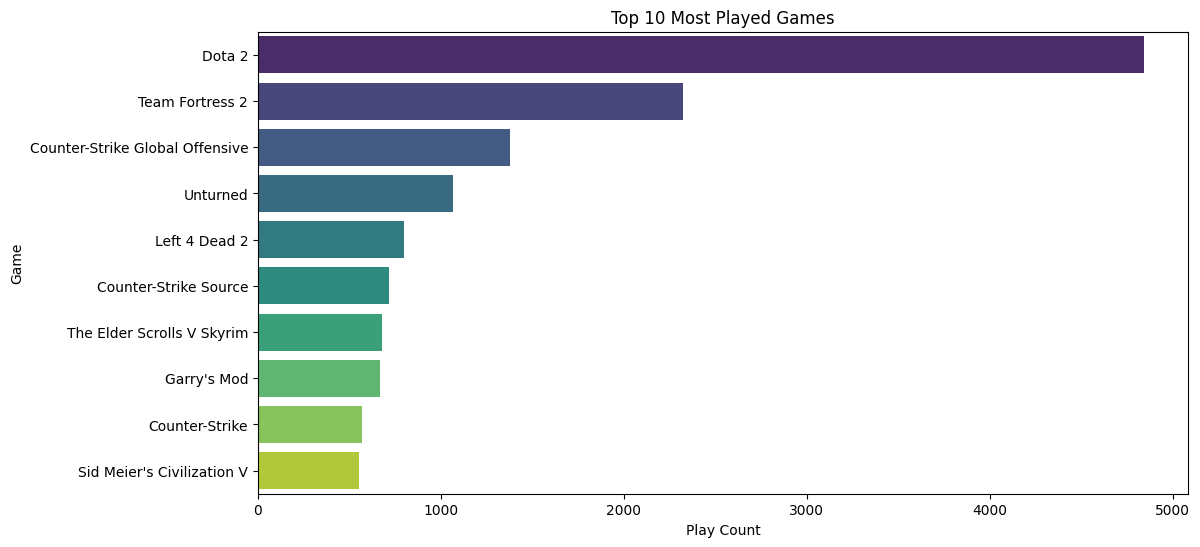

In [9]:
plt.figure(figsize=(12, 6))
top_played_games = play_df['Name of the steam game'].value_counts().head(10)
sns.barplot(x=top_played_games.values, y=top_played_games.index, palette="viridis")
plt.title('Top 10 Most Played Games')
plt.xlabel('Play Count')
plt.ylabel('Game')
plt.show()

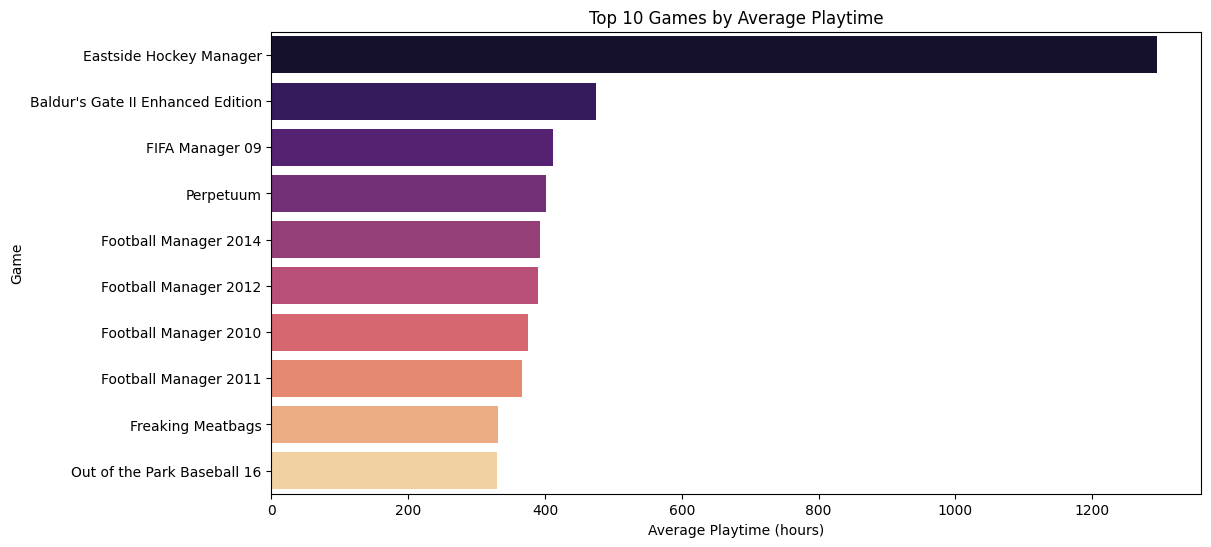

In [10]:
avg_playtime = play_df.groupby('Name of the steam game')['Behavior value'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_playtime.values, y=avg_playtime.index, palette="magma")
plt.title('Top 10 Games by Average Playtime')
plt.xlabel('Average Playtime (hours)')
plt.ylabel('Game')
plt.show()

# Data Mining Methods and Analysis

### Showcasing game recommendations using Collaborative Filtering, Association Rule Mining and Matrix Factorization  

In [11]:
from sklearn.metrics.pairwise import cosine_similarity



Collaborative Filtering:

In [12]:
df = df[df['Behavior name (purchase/play)'] == 'play']  # Focus on play behavior only
# Create a user-game matrix
user_game_matrix = df.pivot_table(index='User ID', columns='Name of the steam game', values='Behavior value').fillna(0)

# Calculate cosine similarity between games
game_similarity = cosine_similarity(user_game_matrix.T)  # Transpose to get game-game similarity
game_similarity_df = pd.DataFrame(game_similarity, index=user_game_matrix.columns, columns=user_game_matrix.columns)

# Function to generate recommendations
def collaborative_filtering_recommendations(game_name, similarity_df, top_n=5):
    """
    Generates game recommendations based on similarity.

    Parameters:
        game_name (str): Name of the game to find recommendations for.
        similarity_df (DataFrame): Game similarity matrix.
        top_n (int): Number of recommendations to return.

    Returns:
        Series: Top N recommended games with similarity scores.
    """
    if game_name not in similarity_df.index:
        return f"Game '{game_name}' not found in the dataset."
    # Sort similar games in descending order and exclude the input game itself
    recommendations = similarity_df[game_name].sort_values(ascending=False).head(top_n + 1)
    return recommendations.iloc[1:]  # Exclude the input game itself

# Example usage
example_game = 'Counter-Strike'
print(f"\nCollaborative Filtering Recommendations for '{example_game}':")
recommendations = collaborative_filtering_recommendations(example_game, game_similarity_df)
print(recommendations)



Collaborative Filtering Recommendations for 'Counter-Strike':
Name of the steam game
Violett                         0.243529
Knightmare Tower                0.243529
David.                          0.243529
Larva Mortus                    0.146117
Infestation Survivor Stories    0.137646
Name: Counter-Strike, dtype: float64




Association Rule Mining:

In [13]:
from mlxtend.frequent_patterns import apriori

# Prepare data in transaction format (User-Item matrix with binary values)
df['Played'] = 1
transaction_df = df.pivot_table(index='User ID', columns='Name of the steam game', values='Played').fillna(0)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# Manually compute association rules (alternative method)
def compute_association_rules(frequent_itemsets, min_confidence=0.5, min_lift=1.0):
    rules = []
    for _, itemset_row in frequent_itemsets.iterrows():
        support = itemset_row['support']
        items = itemset_row['itemsets']
        if len(items) < 2:
            continue  # skip itemsets with fewer than 2 items
        for item in items:
            antecedent = frozenset([item])
            consequent = items - antecedent
            if not consequent:
                continue
            # Confidence calculation
            antecedent_support = frequent_itemsets[frequent_itemsets['itemsets'] == antecedent]['support'].values[0]
            confidence = support / antecedent_support
            # Lift calculation
            consequent_support = frequent_itemsets[frequent_itemsets['itemsets'] == consequent]['support'].values[0]
            lift = confidence / consequent_support
            # Filter based on min_confidence and min_lift
            if confidence >= min_confidence and lift >= min_lift:
                rules.append({
                    'antecedent': antecedent,
                    'consequent': consequent,
                    'support': support,
                    'confidence': confidence,
                    'lift': lift
                })
    return pd.DataFrame(rules)

# Compute association rules
rules_df = compute_association_rules(frequent_itemsets)
print("\nAssociation Rules:\n", rules_df.head())


c:\Users\simphiwe.nonabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Association Rules:
                      antecedent                         consequent   support  \
0                 (Alien Swarm)                    (Left 4 Dead 2)  0.013216   
1                 (Alien Swarm)                  (Team Fortress 2)  0.017004   
2  (Arma 2 Operation Arrowhead)  (Counter-Strike Global Offensive)  0.010396   
3  (Arma 2 Operation Arrowhead)                  (Team Fortress 2)  0.010220   
4           (BioShock Infinite)                    (Left 4 Dead 2)  0.010396   

   confidence      lift  
0    0.519031  7.354561  
1    0.667820  3.262918  
2    0.624339  5.146146  
3    0.613757  2.998768  
4    0.556604  7.886957  





Matrix Factorization:

In [14]:
from sklearn.decomposition import TruncatedSVD

# Decompose user-game matrix using SVD
svd = TruncatedSVD(n_components=10, random_state=42)
user_game_matrix_svd = svd.fit_transform(user_game_matrix)

# Reconstruct the approximation to get recommendations
approximation = svd.inverse_transform(user_game_matrix_svd)
recommendation_df = pd.DataFrame(approximation, index=user_game_matrix.index, columns=user_game_matrix.columns)

# Example recommendation for a specific user
user_id = user_game_matrix.index[0]  # Replace with a specific user ID
print(f"\nMatrix Factorization Recommendations for User {user_id}:")
print(recommendation_df.loc[user_id].sort_values(ascending=False).head(5))



Matrix Factorization Recommendations for User 5250:
Name of the steam game
The Elder Scrolls V Skyrim                     1.550394
Mount & Blade Warband                          1.120259
Team Fortress 2                                0.983991
Call of Duty Modern Warfare 2 - Multiplayer    0.486359
Total War ROME II - Emperor Edition            0.444126
Name: 5250, dtype: float64


### Experimentation


In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from mlxtend.frequent_patterns import apriori

df = df[df['Behavior name (purchase/play)'] == 'play']  # Focus on play behavior only
df = df[['User ID', 'Name of the steam game', 'Behavior value']]


Comparing Collaborative Filtering, Association Rule Mining and Matrix Factorization using relevant metrics

In [16]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create user-game matrices for train and test sets
train_user_game_matrix = train_df.pivot_table(index='User ID', columns='Name of the steam game', values='Behavior value').fillna(0)
test_user_game_matrix = test_df.pivot_table(index='User ID', columns='Name of the steam game', values='Behavior value').fillna(0)


# Collaborative Filtering: Game Similarity Calculation
game_similarity = cosine_similarity(train_user_game_matrix.T)
game_similarity_df = pd.DataFrame(game_similarity, index=train_user_game_matrix.columns, columns=train_user_game_matrix.columns)


# Collaborative Filtering Recommendation Function
def collaborative_filtering_recommendations(user_id, user_game_matrix, similarity_df, top_n=10):
    if user_id not in user_game_matrix.index:
        return []  # No recommendations if user not in training data

    user_history = user_game_matrix.loc[user_id]
    played_games = user_history[user_history > 0].index

    # Calculate scores for unplayed games
    scores = pd.Series(0, index=similarity_df.columns)
    for game in played_games:
        scores += similarity_df[game] * user_history[game]
    scores = scores[~scores.index.isin(played_games)]  # Remove already played games

    # Return top N recommendations
    return scores.sort_values(ascending=False).head(top_n).index.tolist()


# Evaluate Collaborative Filtering
def evaluate_collaborative_filtering(test_df, train_user_game_matrix, similarity_df, top_n=10):
    test_played = test_df.pivot_table(index='User ID', columns='Name of the steam game', values='Behavior value').fillna(0)

    precision_scores = []
    recall_scores = []
    map_scores = []

    for user in test_played.index:
        true_items = test_played.loc[user][test_played.loc[user] > 0].index.tolist()
        recommended_items = collaborative_filtering_recommendations(user, train_user_game_matrix, similarity_df, top_n)

        if not recommended_items or not true_items:
            continue  # Skip users without recommendations or test data

        tp = len(set(true_items) & set(recommended_items))
        precision = tp / top_n
        recall = tp / len(true_items) if len(true_items) > 0 else 0
        ap = average_precision_score(
            [1 if item in true_items else 0 for item in recommended_items],
            [1] * len(recommended_items)
        ) if true_items else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        map_scores.append(ap)

    return {
        "Precision": sum(precision_scores) / len(precision_scores) if precision_scores else 0,
        "Recall": sum(recall_scores) / len(recall_scores) if recall_scores else 0,
        "MAP": sum(map_scores) / len(map_scores) if map_scores else 0
    }


# Association Rule Mining (Apriori)
df['Played'] = 1
transaction_df = df.pivot_table(index='User ID', columns='Name of the steam game', values='Played').fillna(0)

# Generate frequent itemsets using Apriori
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)


# Matrix Factorization using SVD
svd = TruncatedSVD(n_components=10, random_state=42)
user_game_matrix_svd = svd.fit_transform(train_user_game_matrix)

# Reconstruct the approximation to generate recommendations
approximation = svd.inverse_transform(user_game_matrix_svd)
recommendation_df = pd.DataFrame(approximation, index=train_user_game_matrix.index, columns=train_user_game_matrix.columns)


# General Evaluation Function
def evaluate_recommendations(test_df, recommendation_df, top_n=10):
    test_played = test_df.pivot_table(index='User ID', columns='Name of the steam game', values='Behavior value').fillna(0)

    precision_scores = []
    recall_scores = []
    map_scores = []

    for user in test_played.index:
        if user not in recommendation_df.index:
            continue  # Skip users with no recommendations
        
        true_items = test_played.loc[user][test_played.loc[user] > 0].index.tolist()
        recommended_items = recommendation_df.loc[user].sort_values(ascending=False).index[:top_n]
        
        tp = len(set(true_items) & set(recommended_items))
        precision = tp / top_n
        recall = tp / len(true_items) if len(true_items) > 0 else 0
        ap = average_precision_score(
            [1 if item in true_items else 0 for item in recommended_items],
            [1] * len(recommended_items)
        ) if true_items else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        map_scores.append(ap)

    return {
        "Precision": sum(precision_scores) / len(precision_scores) if precision_scores else 0,
        "Recall": sum(recall_scores) / len(recall_scores) if recall_scores else 0,
        "MAP": sum(map_scores) / len(map_scores) if map_scores else 0
    }


# Evaluate All Methods
collaborative_results = evaluate_collaborative_filtering(test_df, train_user_game_matrix, game_similarity_df)
apriori_results = evaluate_recommendations(test_df, transaction_df)
matrix_factorization_results = evaluate_recommendations(test_df, recommendation_df)


# Display Results
print("\nEvaluation Results for Collaborative Filtering:")
for metric, value in collaborative_results.items():
    print(f"{metric}: {value:.4f}")

print("\nEvaluation Results for Association Rule Mining:")
for metric, value in apriori_results.items():
    print(f"{metric}: {value:.4f}")

print("\nEvaluation Results for Matrix Factorization:")
for metric, value in matrix_factorization_results.items():
    print(f"{metric}: {value:.4f}")


c:\Users\simphiwe.nonabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Evaluation Results for Collaborative Filtering:
Precision: 0.0184
Recall: 0.0726
MAP: 0.0184

Evaluation Results for Association Rule Mining:
Precision: 0.1504
Recall: 0.8352
MAP: 0.1504

Evaluation Results for Matrix Factorization:
Precision: 0.0287
Recall: 0.1178
MAP: 0.0287
